
Name: Nisarg Rade
email: nisargraden@gmail.com

Run in colab click here : https://colab.research.google.com/drive/1ahgILffrUyQxjQi-9g15rDHvN8Abgkue?usp=sharing

please use colab for smooth running

Connect google drive to download / load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Run this cell if data is not downloaded
!mkdir -p /content/drive/MyDrive/parallel_dots/
!wget -P /content/drive/MyDrive/parallel_dots/ http://www.cs.cmu.edu/~ehsiao/3drecognition/CMU10_3D.zip
!pip install -r /content/drive/MyDrive/parallel_dots/requirements.txt
TARGET_FOLDER = "/content/drive/MyDrive/parallel_dots/"

# Clone the repository into the target folder
!git clone https://github.com/facebookresearch/segment-anything-2.git $TARGET_FOLDER

In [2]:
# comment if not using colab
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'
else:
  !git clone https://github.com/facebookresearch/segment-anything.git
  !cd segment-anything
  !pip install -e .



PyTorch version: 2.4.0+cu121
Torchvision version: 0.19.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-l0zpaoqi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-l0zpaoqi
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 7e1596c0b6462eb1d1ba7e1492430fed95023598
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
  Created wh

 Import necessary libraries

In [4]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os, glob, shutil
import matplotlib.patches as patches
import re
import time
import cv2

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


using device: cuda


load the sam2 model for prediction
please provide correct path for the model if stored at different place

In [5]:
checkpoint = "/content/drive/MyDrive/parallel_dots/segment-anything-2/checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
tempfolder = "./tempdir"
# Initialize SAM2 model and predictors
sam2 = build_sam2(model_cfg, checkpoint, device='cuda', apply_postprocessing=False)
predictor_prompt = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))
mask_generator = SAM2AutomaticMaskGenerator(sam2)
predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')

Create required functions for SAM2 detection

In [6]:
def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

def cleardir(tempfolder):
    filepaths = glob.glob(tempfolder + "/*")
    for filepath in filepaths:
        os.unlink(filepath)
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
def get_mask_bounding_box(mask):
    # Find indices where the mask is non-zero
    if np.sum(mask) == 0:
        print("Empty mask detected, cannot compute bounding box.")
        return None

    # Find indices where the mask is non-zero
    mask_indices = np.argwhere(mask)

    if mask_indices.size == 0:
        print("No non-zero indices found in the mask.")
        return None
    mask_indices = np.argwhere(mask)
    ymin, xmin = mask_indices.min(axis=0)
    ymax, xmax = mask_indices.max(axis=0)
    return xmin, ymin, xmax, ymax

## **Implemented the function to get the point from first_image/mask**

In [7]:
def process_img_png_mask(image_path, mask_path, visualize=True):


    img = Image.open(image_path)
    mask = Image.open(mask_path)
    mask_np = np.array(mask)

    if visualize:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img)
        ax[1].imshow(mask_np, cmap='gray')
        plt.show()

    # Extract bounding box (xmin, xmax, ymin, ymax)
    ymin, ymax = np.min(np.where(mask_np)[0]), np.max(np.where(mask_np)[0])
    xmin, xmax = np.min(np.where(mask_np)[1]), np.max(np.where(mask_np)[1])
    print([xmin, xmax, ymin, ymax])
    return [xmin, xmax, ymin, ymax]

Created a function to detect the mask and return the bounding box

In [8]:
def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize):
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)
    shutil.copy(imgpath1, tempfolder + "/00000.jpg")
    shutil.copy(imgpath2, tempfolder + "/00001.jpg")

    inference_state = predictor_vid.init_state(video_path="./tempdir")
    predictor_vid.reset_state(inference_state)
    ann_frame_idx = 0

    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        _, out_obj_ids, out_mask_logits = predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )

    video_segments = {}
    bounding_boxes = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            if out_mask.sum() > 0:  # Check if the mask has any positive values
                bbox = get_mask_bounding_box(out_mask[0])
                if bbox is not None:
                    bounding_boxes[out_obj_id] = bbox

    if visualize:
        fig, ax = plt.subplots()
        plt.title("Original image object ::")
        ax.imshow(Image.open(tempfolder + "/00000.jpg"))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title("Detected object in test image ::")
        plt.imshow(Image.open(tempfolder + "/00001.jpg"))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            if out_mask.sum() > 0:  # Check if the mask has any positive values
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    print(bounding_boxes)
    return video_segments, bounding_boxes


### **Created functions to get object detection performance for each product**

In [9]:
# Function to evaluate detection performance
def evaluate_detection_performance(pred_boxes, gt_boxes):
    ious = []
    for pred_box, gt_box in zip(pred_boxes, gt_boxes):
        if pred_box is None:  # Handle missing detections
            ious.append(0)  # IoU is 0 when the detection fails
        else:
            iou = calculate_iou(pred_box, gt_box)
            ious.append(iou)
    mean_iou = np.mean(ious)
    precision = sum([iou >= 0.5 for iou in ious]) / len(ious) if ious else 0
    recall = sum([iou >= 0.5 for iou in ious]) / len(gt_boxes) if gt_boxes else 0
    return {
        "mean_iou": mean_iou,
        "precision": precision,
        "recall": recall
    }

# IoU Calculation
def calculate_iou(boxA, boxB):
    if boxA is None or boxB is None:
        return 0  # Return 0 IoU when any box is None
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Example use case with images (replace with actual paths and details as required)
def detect_objects(reference_img, reference_mask, target_img,visualizze):
  if visualizze:
    visulaize=True
  else:
    visulaize=False
  firstimgpath=reference_img
  firstimgmaskpath=reference_mask
  [xmin, xmax, ymin, ymax] = process_img_png_mask(firstimgpath, firstimgmaskpath, True)


  secondimgpath=target_img
  secondimg = Image.open(secondimgpath)

  print(f"hbasfkjdaesfkjbhnfkjbnakjbdegkjbneg{visulaize}")
  op,bounding_box = track_item_boxes(firstimgpath, secondimgpath, [([xmin, xmax, ymin, ymax], 1)], True)

  output_masks = op[1]

  if output_masks is None or np.sum(output_masks) == 0:
        return None
  relevant_mask = output_masks[1]


  return bounding_box[1]

def calculate_box_distance(box1, box2):

    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2
    center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
    center2 = ((x1_gt + x2_gt) / 2, (y1_gt + y2_gt) / 2)
    return np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

Main code to drive through the first image/mask of every product and perform detection as save the results in a txt file

In [ ]:

# Directory paths
data_path = '/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D'  # Replace with the correct path
output_path = "/content/output"  # Directory to save results

# Define the initial reference images and masks
reference_pairs = {
    "can_chowder": ("can_chowder_000001.jpg", "can_chowder_000001_1_gt.png"),
    "can_soymilk": ("can_soymilk_000001.jpg", "can_soymilk_000001_1_gt.png"),
    "can_tomatosoup": ("can_tomatosoup_000001.jpg", "can_tomatosoup_000001_1_gt.png"),
    "carton_oj": ("carton_oj_000001.jpg", "carton_oj_000001_1_gt.png"),
    "carton_soymilk": ("carton_soymilk_000001.jpg", "carton_soymilk_000001_1_gt.png"),
    "diet_coke": ("diet_coke_000001.jpg", "diet_coke_000001_1_gt.png"),
    "hc_potroastsoup": ("hc_potroastsoup_000001.jpg", "hc_potroastsoup_000001_1_gt.png"),
    "juicebox": ("juicebox_000001.jpg", "juicebox_000001_1_gt.png"),
    "rice_tuscan": ("rice_tuscan_000001.jpg", "rice_tuscan_000001_1_gt.png"),
    "ricepilaf": ("ricepilaf_000001.jpg", "ricepilaf_000001_1_gt.png")
}

results = {}
for object_name, (ref_img_name, ref_mask_name) in reference_pairs.items():
    # Load reference image and mask
    ref_img_path = os.path.join(data_path, ref_img_name)
    ref_mask_path = os.path.join(data_path, ref_mask_name)
    reference_img = cv2.imread(ref_img_path)
    reference_mask = cv2.imread(ref_mask_path, cv2.IMREAD_GRAYSCALE)

    # Get all images of the current object type
    object_images = [img for img in os.listdir(data_path) if img.startswith(object_name) and img.endswith('.jpg')]

    pred_boxes = []
    gt_boxes = []

    for img_name in object_images:

        img_path = os.path.join(data_path, img_name)
        mask_path = img_path.replace(".jpg", "_1_gt.png")
        print(img_path,mask_path)
        # Load target image and ground truth mask



        if img_name.endswith("000002.jpg"):
            visualizze = True
        else:
            visualizze = False


        target_img = img_path
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Detect object using the first reference pair
        pred_box = detect_objects(ref_img_path, ref_mask_path, target_img, visualizze)


        if pred_box is None :
            pred_boxes.append(None)
            gt_boxes.append(None)
            continue
        # if str(pred_box) == "(373, 154, 463, 290)":
        #     print("appending none")
        #     pred_boxes.append(None)
        #     gt_boxes.append(None)
        #     continue

        # Initialize variables to find the closest mask
        best_gt_box = None
        min_distance = float('inf')

        # Iterate through possible mask files
        for i in range(1, 4):
            mask_path = img_path.replace(".jpg", f"_{i}_gt.png")
            if os.path.exists(mask_path):
                gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                gt_box = get_mask_bounding_box(gt_mask)

                if gt_box is not None:
                    distance = calculate_box_distance(pred_box, gt_box)
                    if distance < min_distance:
                        min_distance = distance
                        best_gt_box = gt_box

        pred_boxes.append(pred_box)
        gt_boxes.append(best_gt_box)


    # Calculate evaluation metrics
    performance = evaluate_detection_performance(pred_boxes, gt_boxes)
    results[object_name] = performance
    print(f"Performance for {object_name}: {performance}")

# Save results
with open(os.path.join(output_path, "detection_performance.txt"), "w") as f:
    for object_name, performance in results.items():
        f.write(f"{object_name}: {performance}\n")

print("Object detection performance evaluation completed.")

# Display one image for each object and its detection

/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000022.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000022_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000033.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000033_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000006.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000006_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000018.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000018_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000043.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000043_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000004.jpg /content/drive/MyDrive/parall

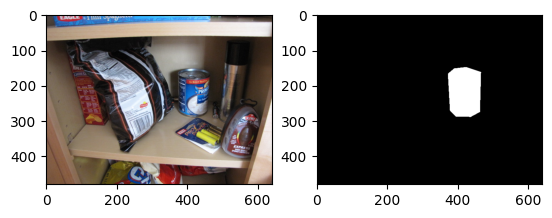

[371, 464, 150, 290]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


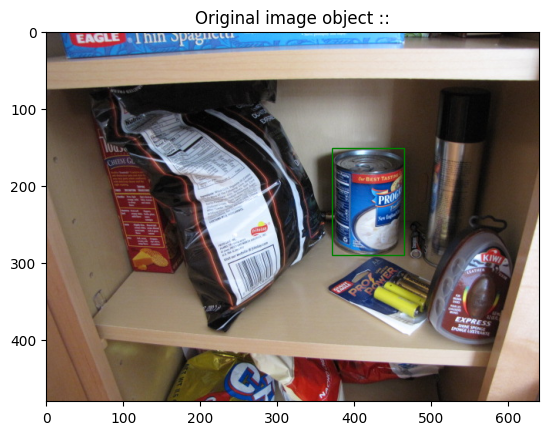

{1: (249, 150, 331, 278)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000020.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000020_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000045.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000045_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000049.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000049_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000005.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000005_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000032.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000032_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_chowder_000025.jpg /co

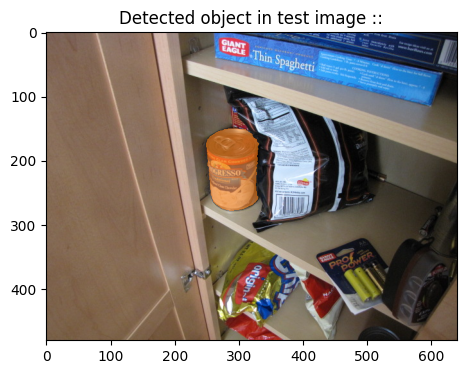

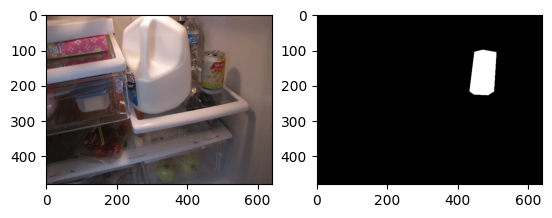

[432, 508, 101, 229]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


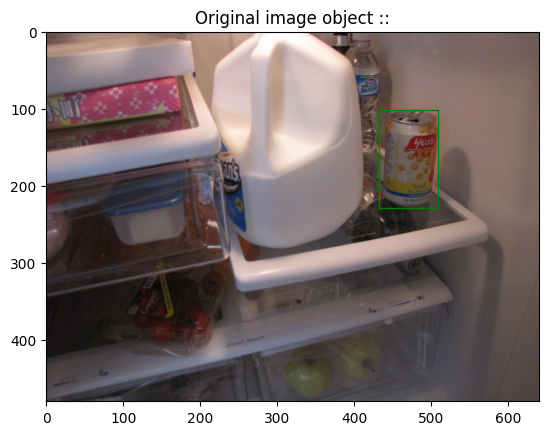

{1: (427, 178, 511, 306)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000047.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000047_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000031.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000031_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000045.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000045_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000049.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000049_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000017.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000017_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_soymilk_000037.jpg /co

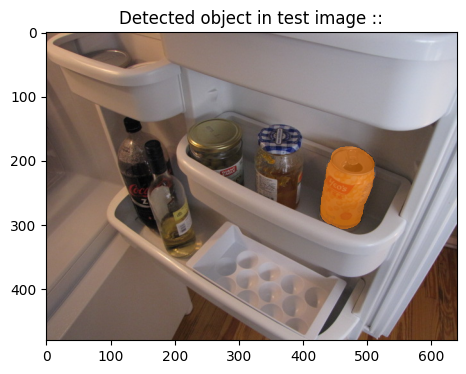

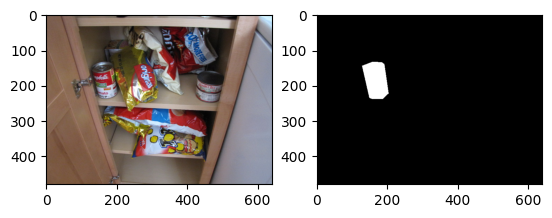

[127, 202, 135, 239]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


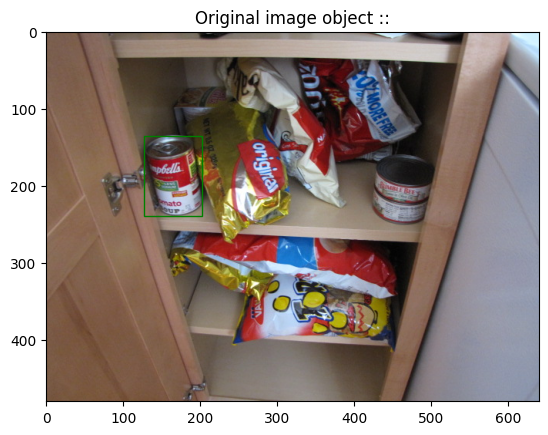

{1: (169, 131, 232, 224)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000036.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000036_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000024.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000024_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000015.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000015_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000047.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000047_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000042.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/can_tomatosoup_000042_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data

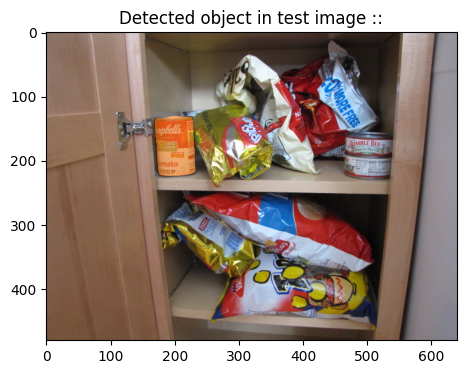

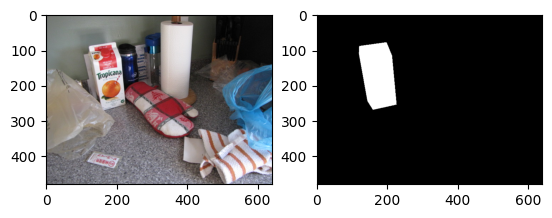

[118, 225, 80, 270]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


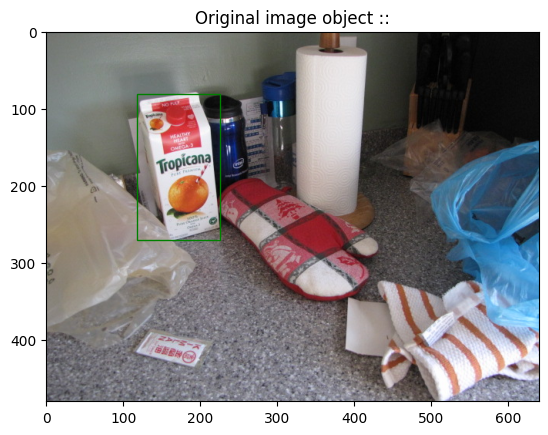

{1: (49, 134, 213, 327)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000025.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000025_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000036.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000036_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000018.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000018_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000038.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000038_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000012.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000012_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_oj_000046.jpg /content/drive/MyDrive/par

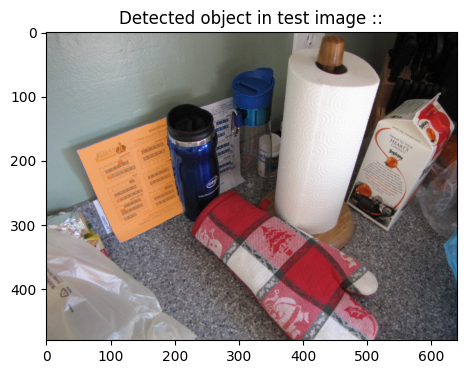

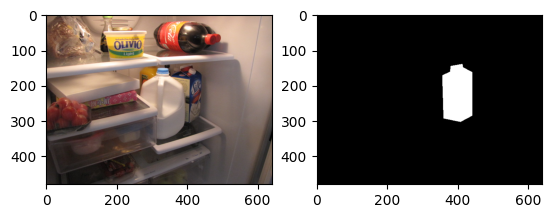

[355, 439, 141, 304]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


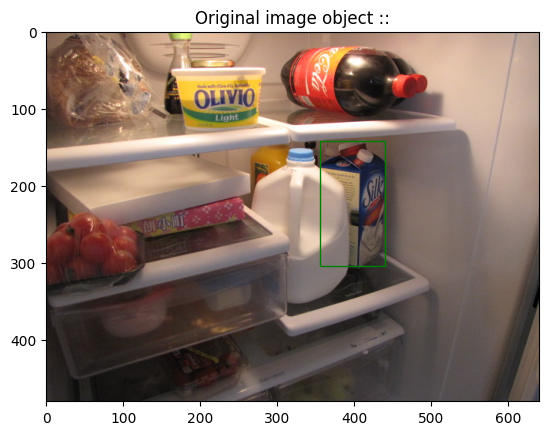

{1: (186, 169, 296, 337)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000003.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000003_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000029.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000029_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000039.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000039_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000048.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000048_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000035.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/carton_soymilk_000035_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data

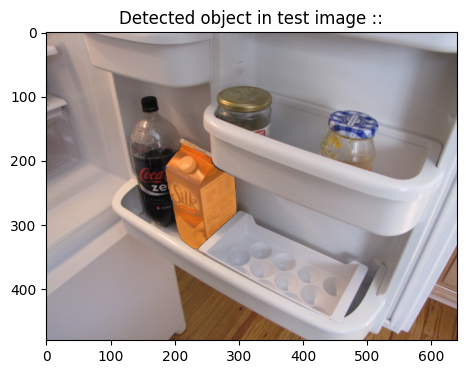

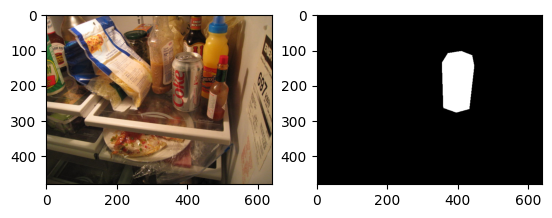

[354, 445, 104, 277]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


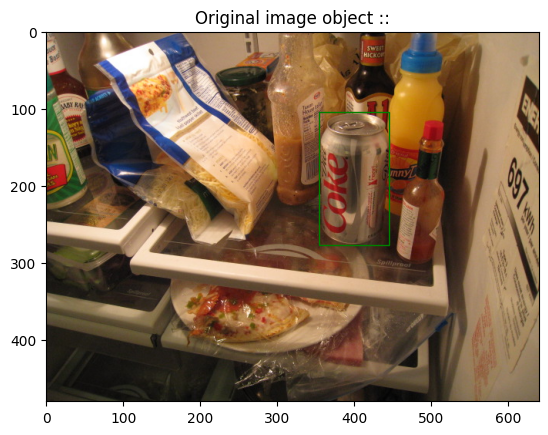

{1: (401, 141, 478, 280)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000029.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000029_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000010.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000010_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000039.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000039_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000004.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000004_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000024.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000024_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/diet_coke_000019.jpg /content/drive/MyDrive/pa

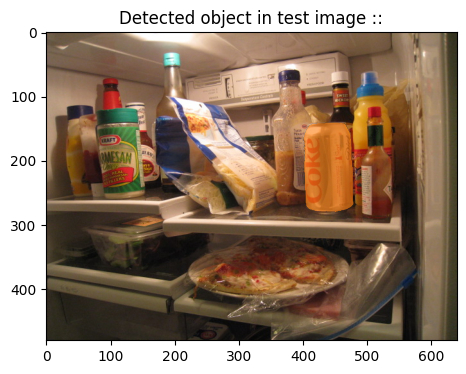

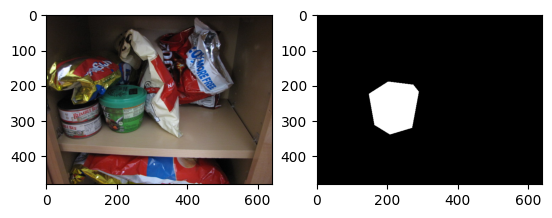

[147, 288, 191, 339]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


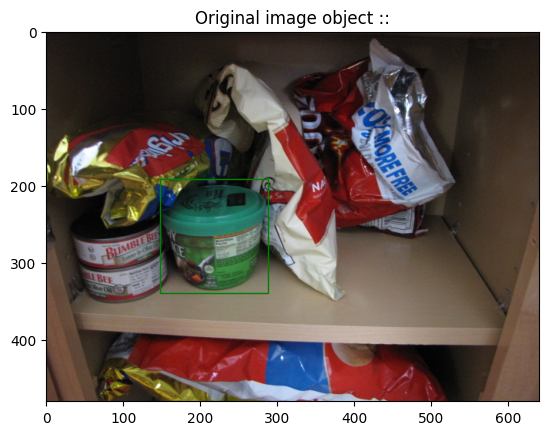

{1: (152, 42, 267, 148)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000050.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000050_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000007.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000007_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000049.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000049_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000009.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000009_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000031.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/hc_potroastsoup_000031_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU1

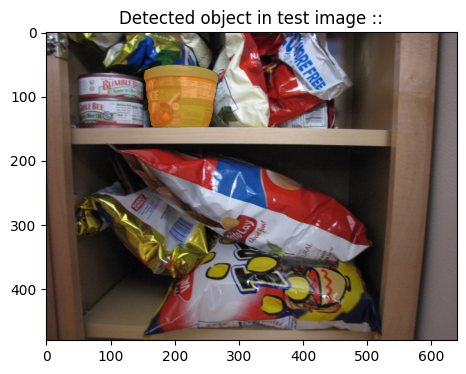

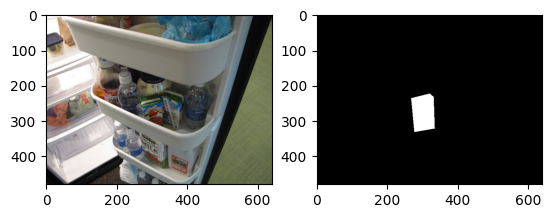

[267, 333, 224, 332]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


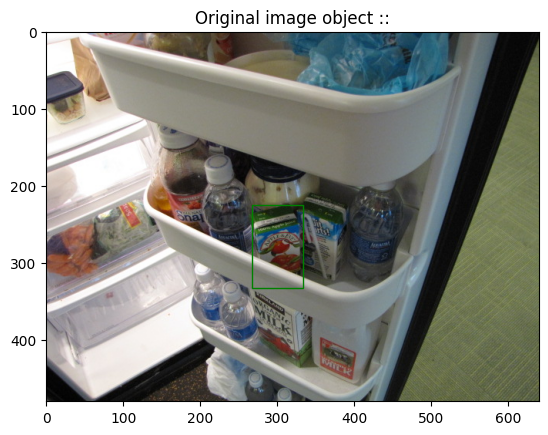

{1: (322, 231, 374, 317)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000048.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000048_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000027.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000027_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000043.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000043_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000009.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000009_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000036.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000036_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/juicebox_000025.jpg /content/drive/MyDrive/parallel_dots

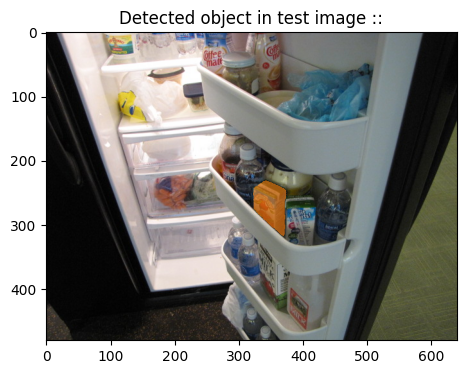

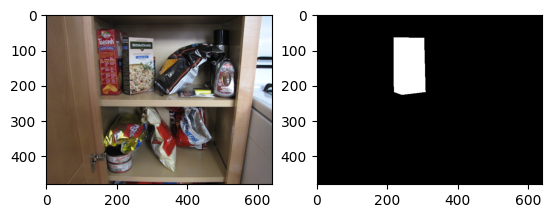

[217, 307, 66, 227]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


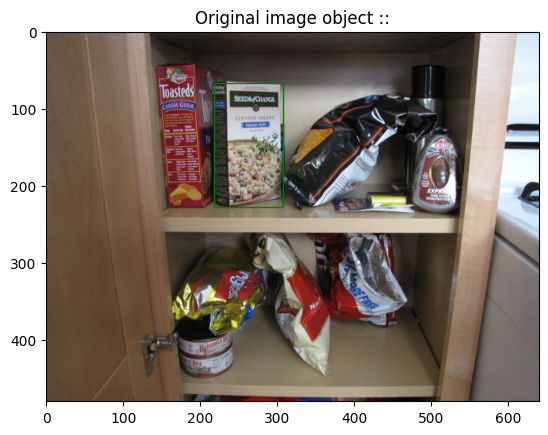

{1: (192, 188, 286, 317)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000040.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000040_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000009.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000009_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000045.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000045_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000032.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000032_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000029.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000029_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/rice_tuscan_000030.jpg /co

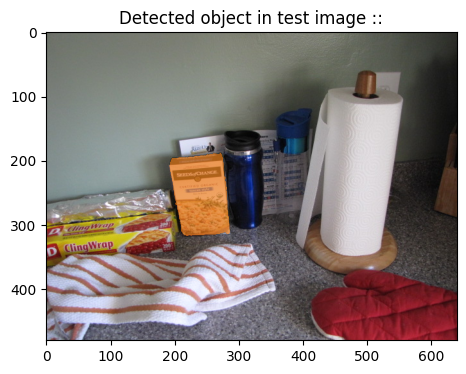

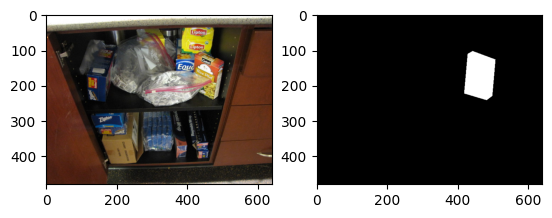

[417, 505, 104, 242]
hbasfkjdaesfkjbhnfkjbnakjbdegkjbnegTrue


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


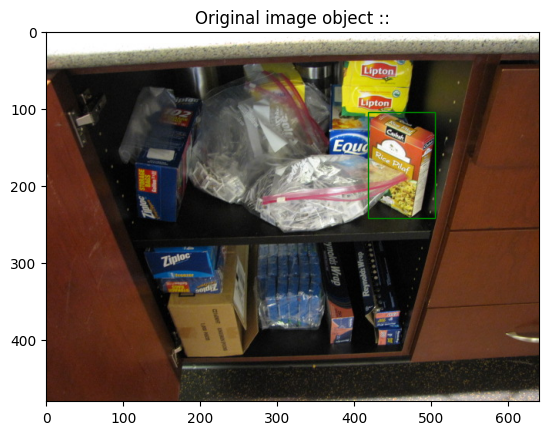

{1: (418, 107, 503, 241)}
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000029.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000029_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000022.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000022_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000036.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000036_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000031.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000031_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000012.jpg /content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000012_1_gt.png
/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D/ricepilaf_000009.jpg /content/drive/MyDrive/pa

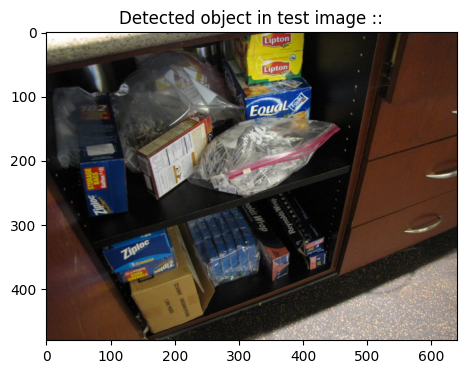

In [13]:
data_path = '/content/drive/MyDrive/parallel_dots/CMU10_3D/CMU10_3D/data_2D'
output_path = "/content/output"
reference_pairs = {
    "can_chowder": ("can_chowder_000001.jpg", "can_chowder_000001_1_gt.png"),
    "can_soymilk": ("can_soymilk_000001.jpg", "can_soymilk_000001_1_gt.png"),
    "can_tomatosoup": ("can_tomatosoup_000001.jpg", "can_tomatosoup_000001_1_gt.png"),
    "carton_oj": ("carton_oj_000001.jpg", "carton_oj_000001_1_gt.png"),
    "carton_soymilk": ("carton_soymilk_000001.jpg", "carton_soymilk_000001_1_gt.png"),
    "diet_coke": ("diet_coke_000001.jpg", "diet_coke_000001_1_gt.png"),
    "hc_potroastsoup": ("hc_potroastsoup_000001.jpg", "hc_potroastsoup_000001_1_gt.png"),
    "juicebox": ("juicebox_000001.jpg", "juicebox_000001_1_gt.png"),
    "rice_tuscan": ("rice_tuscan_000001.jpg", "rice_tuscan_000001_1_gt.png"),
    "ricepilaf": ("ricepilaf_000001.jpg", "ricepilaf_000001_1_gt.png")
}

results = {}
for object_name, (ref_img_name, ref_mask_name) in reference_pairs.items():
    # Load reference image and mask
    ref_img_path = os.path.join(data_path, ref_img_name)
    ref_mask_path = os.path.join(data_path, ref_mask_name)
    reference_img = cv2.imread(ref_img_path)
    reference_mask = cv2.imread(ref_mask_path, cv2.IMREAD_GRAYSCALE)

    # Get all images of the current object type
    object_images = [img for img in os.listdir(data_path) if img.startswith(object_name) and img.endswith('.jpg')]

    pred_boxes = []
    gt_boxes = []

    for img_name in object_images:

        img_path = os.path.join(data_path, img_name)
        mask_path = img_path.replace(".jpg", "_1_gt.png")
        print(img_path,mask_path)
        # Load target image and ground truth mask



        if img_name.endswith("000002.jpg"):
            detect_objects(ref_img_path, ref_mask_path, img_path, visualizze=True)
        else:
            continue


Display the performance result

In [14]:

file_path = '/content/outputdetection_performance.txt'

# Open and read the file
with open(file_path, 'r') as file:
    content = file.read()

# Display the content
print(content)


can_chowder: {'mean_iou': 0.3875101071600811, 'precision': 0.44, 'recall': 0.44}
can_soymilk: {'mean_iou': 0.34217088830525144, 'precision': 0.34, 'recall': 0.34}
can_tomatosoup: {'mean_iou': 0.29593599595804176, 'precision': 0.28, 'recall': 0.28}
carton_oj: {'mean_iou': 0.36959294859602726, 'precision': 0.4, 'recall': 0.4}
carton_soymilk: {'mean_iou': 0.5102140608757126, 'precision': 0.54, 'recall': 0.54}
diet_coke: {'mean_iou': 0.7600907878025357, 'precision': 0.84, 'recall': 0.84}
hc_potroastsoup: {'mean_iou': 0.7568471381463258, 'precision': 0.82, 'recall': 0.82}
juicebox: {'mean_iou': 0.24683781655947798, 'precision': 0.2, 'recall': 0.2}
rice_tuscan: {'mean_iou': 0.5685131976807216, 'precision': 0.58, 'recall': 0.58}
ricepilaf: {'mean_iou': 0.3519034375335188, 'precision': 0.34, 'recall': 0.34}



 .

**Evaluation using Pycocotool**s:

 :calculating performance metrics using pycocotools

 :tried code below for calculating through pycocotools but was not able to  
  provide all parameters needed for calculating it.

**Tried with Intersection over union used above**:

  calculated the performance metrics using function used in above code and it is giving performance metrics for each product

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np

# example boxes
pred_boxes = [
    {'image_id': 1, 'category_id': 1, 'bbox': [50, 50, 100, 100], 'score': 0.9},
    {'image_id': 1, 'category_id': 1, 'bbox': [30, 30, 50, 50], 'score': 0.75},

]

gt_boxes = [
    {'image_id': 1, 'category_id': 1, 'bbox': [48, 48, 100, 100], 'area': 10000, 'iscrowd': 0},
    {'image_id': 1, 'category_id': 1, 'bbox': [30, 30, 50, 50], 'area': 2500, 'iscrowd': 0},

]

# Convert lists to COCO-like JSON format
def create_coco_annotations(boxes, is_gt=True):
    coco_format = {'images': [], 'annotations': [], 'categories': []}

    # Adding image info
    image_ids = list(set([box['image_id'] for box in boxes]))
    for img_id in image_ids:
        coco_format['images'].append({'id': img_id})

    # Adding category info
    coco_format['categories'].append({'id': 1, 'name': 'object'})  # Assuming one category

    # Adding annotations
    annotation_id = 1
    for box in boxes:
        annotation = {
            'id': annotation_id,
            'image_id': box['image_id'],
            'category_id': box['category_id'],
            'bbox': box['bbox'],
        }
        if is_gt:
            annotation['area'] = box['area']
            annotation['iscrowd'] = box['iscrowd']
        else:
            annotation['score'] = box['score']
        coco_format['annotations'].append(annotation)
        annotation_id += 1

    return coco_format

# Create COCO-like annotations
gt_coco = COCO(create_coco_annotations(gt_boxes))
pred_coco = gt_coco.loadRes(create_coco_annotations(pred_boxes, is_gt=False))

# Evaluate with COCOeval
coco_eval = COCOeval(gt_coco, pred_coco, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
